In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline

In [2]:
# Load data
infile = open('whiskeys.pkl','rb')
my_list = pickle.load(infile)
infile.close()

df = pd.DataFrame(my_list)
# Take a look at the datatypes
df.head()

,whiskey_name,rating,rating_source,user_rating,num_reviews,price,brand,country,state,spirit_type,taste
0,Method & Madness Single Grain Whisky,NaN,None,5.0,2.0,59.99,Method & Madness,Ireland,None,Irish Whiskey,"[Rich, Oak, Grain, Balanced]"
1,Shieldaig Islay Single Malt,NaN,None,3.7,178.0,21.99,Shieldaig,Scotland,Islay & Islands,Scotch,"[Rich, Peat, Smoke, Balanced]"
2,Riverboat Rye Whiskey,NaN,None,3.8,40.0,19.99,Riverboat,United States,Indiana,American Whiskey,"[Intense, Spice, Toast, Balanced]"
3,Whistlepig 10 Year Private Rye Barrel Select,96.0,Wine Enthusiast,4.6,14.0,91.99,WhistlePig,United States,Vermont,American Whiskey,"[Rich, Caramel, Vanilla, Spice, Long]"
4,Highland Queen Majesty Sauternes Finish Single...,NaN,None,4.1,22.0,17.99,Highland Queen Majesty,Scotland,Highland,Scotch,"[Medium, Vanilla, Cherry, Balanced]"


In [5]:
df.value_counts

<bound method DataFrame.value_counts of                                            whiskey_name  rating  \
0                  Method & Madness Single Grain Whisky     NaN   
1                           Shieldaig Islay Single Malt     NaN   
2                                 Riverboat Rye Whiskey     NaN   
3          Whistlepig 10 Year Private Rye Barrel Select    96.0   
4     Highland Queen Majesty Sauternes Finish Single...     NaN   
...                                                 ...     ...   
1194                Colorado Gold Bourbon Barrel Select     NaN   
1195                                    Old Forester 86    95.0   
1196      Little Book "Lessons Honored" Bourbon Whiskey     NaN   
1197                 High West American Prairie Bourbon    93.0   
1198                                 Jack Daniels Black     NaN   

                   rating_source  user_rating  num_reviews   price  \
0                           None          5.0          2.0   59.99   
1              

#### Challenge 1
Build a linear model that uses only a constant term (a column of ones) to predict a continuous outcome (like domestic total gross). How can you interpret the results of this model? What does it predict? Make a plot of predictions against actual outcome. Make a histogram of residuals. How are the residuals distributed?

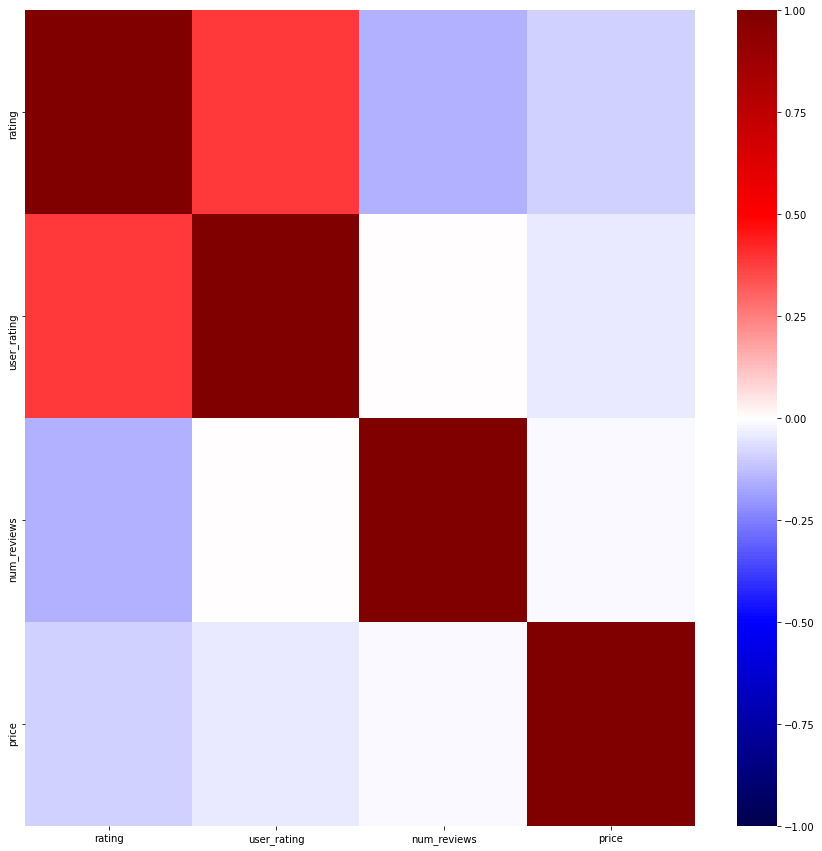

In [3]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df.corr(), cmap="seismic", vmin=-1, vmax=1, ax=ax);

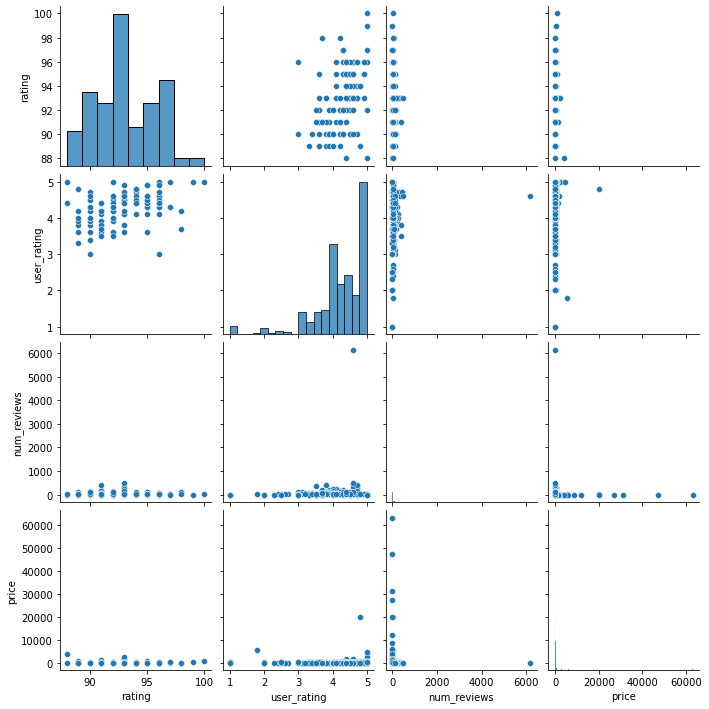

In [6]:
sns.pairplot(df);

Text(0.5, 1.0, 'User Rating vs Price on Total Wine Website')

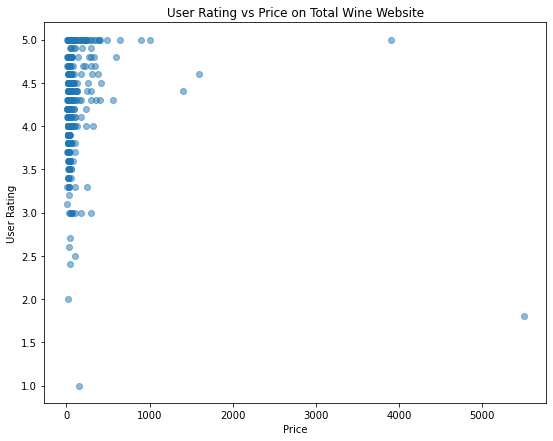

In [4]:
fig, ax = plt.subplots(figsize=(9, 7))

price_x = df[['price']]
user_rating_y = df['user_rating']

ax.scatter(price_x, user_rating_y, alpha=.5)
ax.set_xlabel('Price')
ax.set_ylabel('User Rating')
ax.set_title('User Rating vs Price on Total Wine Website')

In [5]:
lr = LinearRegression()

lr.fit(price_x, user_rating_y)

lr.score(price_x, user_rating_y) #R2

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [6]:
from sklearn.metrics import mean_squared_error, r2_score

In [13]:
preds = lr.predict(price_x)

np.sqrt(mean_squared_error(user_rating_y, preds))

r2_score(user_rating_y, preds)

0.5198809317726566

NotFittedError: This LinearRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

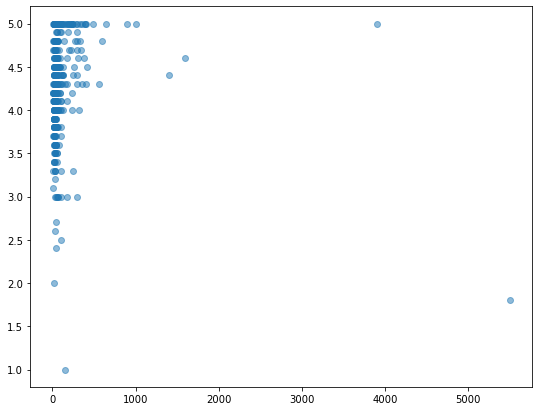

In [7]:
fig, ax = plt.subplots(figsize=(9, 7))

price_x = df[['price']]
user_rating_y = df['user_rating']
ax.scatter(price_x, user_rating_y, alpha=.5)

_x = np.linspace(price_x.min(), user_rating_y.max())
_y = lr.predict(_x)

ax.plot(_x, _y, color='orange')

In [17]:
print(f'slope: {lr.coef_[0]:.2f}')
print(f'y-intercept: {lr.intercept_:.2f}')

slope: 0.01
y-intercept: 3.72


In [18]:
from sklearn.preprocessing import OneHotEncoder

In [19]:
df['spirit_type'].value_counts()

American Whiskey    2
Scotch              2
Irish Whiskey       1
Name: spirit_type, dtype: int64

In [20]:
cat_X = df.loc[:, ['spirit_type']]

cat_y = df['user_rating']

In [21]:
cat_X

,spirit_type
0,Irish Whiskey
1,Scotch
2,American Whiskey
3,American Whiskey
4,Scotch


In [22]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(cat_X)

ohe_X = ohe.transform(cat_X)

columns = ohe.get_feature_names(['spirit_type'])

ohe_X_df = pd.DataFrame(ohe_X, columns=columns, index=cat_X.index)

ohe_X_df.head()

,spirit_type_Irish Whiskey,spirit_type_Scotch
0,1.0,0.0
1,0.0,1.0
2,0.0,0.0
3,0.0,0.0
4,0.0,1.0


In [23]:
cat_lr = LinearRegression()

cat_lr.fit(ohe_X_df, cat_y)

cat_lr.score(ohe_X_df, cat_y)

0.7168989547038329

In [24]:
cat_lr.coef_

array([ 0.85, -0.25])

Combined

In [26]:
combined_df = pd.concat([ohe_X_df, df[['user_rating']]], axis=1)
combined_df.head()

,spirit_type_Irish Whiskey,spirit_type_Scotch,user_rating
0,1.0,0.0,5.0
1,0.0,1.0,3.7
2,0.0,0.0,3.8
3,0.0,0.0,4.5
4,0.0,1.0,4.1


In [27]:
combined_lr = LinearRegression()

combined_lr.fit(combined_df, cat_y)

combined_lr.score(combined_df, cat_y)

1.0

In [28]:
combined_lr.coef_, combined_lr.intercept_

(array([ 6.51372456e-16, -2.22044605e-16,  1.00000000e+00]), 0.0)

In [38]:
# Create your feature matrix (X) and target vector (y)
X = combined_df.iloc[:, :2]
y = combined_df.iloc[:, 2:]

#y, x = patsy.dmatrices('X1 + X2 ~ y', data=combined_df, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

/Users/willnobles/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            user_rating   R-squared (uncentered):                   0.614
Model:                            OLS   Adj. R-squared (uncentered):              0.357
Method:                 Least Squares   F-statistic:                              2.391
Date:                Sun, 17 Jan 2021   Prob (F-statistic):                       0.239
Time:                        16:19:44   Log-Likelihood:                         -11.943
No. Observations:                   5   AIC:                                      27.89
Df Residuals:                       3   BIC:                                      27.10
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
spirit_type_Irish Whiskey     5.0000      3.404      1.469      0.238      -5.834      15.834
spirit_type_Scotch            3.9000      2.407      1.620      0.204      -3.761      11.561
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.007
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.794
Skew:                           0.432   Prob(JB):                        0.672
Kurtosis:                       1.250   Cond. No.                         1.41
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

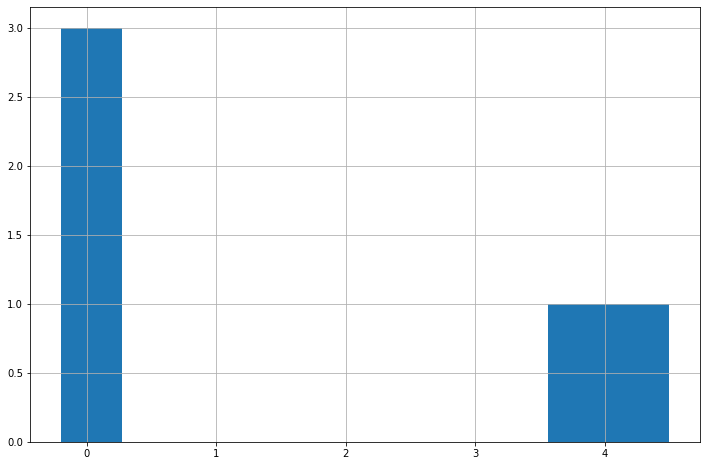

In [42]:
fit.resid.hist(figsize=(12,8));

#### Challenge 2
Repeat the process of challenge one, but also add one continuous (numeric) predictor variable. Also add plots of model prediction against your feature variable and residuals against feature variable. How can you interpret what's happening in the model?

In [69]:
from sklearn.model_selection import train_test_split

X = df[['price', 'country']]

y = df['user_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [70]:
cat_variables = ['country']

X_train_cat = X_train[cat_variables]

In [71]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False, drop='first')
ohe.fit(X_train_cat) 
cats = ohe.transform(X_train_cat)

In [72]:
columns = ohe.get_feature_names(cat_variables)
X_train_cat_df = pd.DataFrame(cats, columns=columns, index=X_train_cat.index)
X_train_cat_df.head()

,country_Scotland,country_United States
2,0.0,1.0
0,0.0,0.0
4,1.0,0.0


In [73]:
X_test_cat = X_test[['country']]

cats_test = ohe.transform(X_test_cat)                           # REMEMBER ONLY TRANSFORM ON TEST SET

cat_columns = ohe.get_feature_names(['country'])
X_test_cat_df = pd.DataFrame(cats_test, columns=cat_columns, index=X_test_cat.index)
X_test_cat_df.head()

,country_Scotland,country_United States
3,0.0,1.0
1,1.0,0.0


In [74]:
X_train_cont = X_train[['price']]

X_train_cont.head()

,price
2,19.99
0,59.99
4,17.99


In [75]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont)
X_train_scaled = ss.transform(X_train_cont)

cont_columns = X_train_cont.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)

X_train_scaled_df.head()

,price
2,-0.654783
0,1.412953
4,-0.758170


In [77]:
X_test_cont = X_test[['price']]

X_test_cont.head()

,price
3,91.99
1,21.99


In [78]:
X_test_scaled = ss.transform(X_test_cont)

cont_columns = X_test_cont.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont.index)

X_test_scaled_df.head()

,price
3,3.067143
1,-0.551396


In [79]:
X_train_combined = pd.concat([X_train_cat_df, X_train_scaled_df], axis='columns')

X_train_combined.head()

,country_Scotland,country_United States,price
2,0.0,1.0,-0.654783
0,0.0,0.0,1.412953
4,1.0,0.0,-0.758170


In [80]:
X_test_combined = pd.concat([X_test_cat_df, X_test_scaled_df], axis='columns')

X_test_combined.head()

,country_Scotland,country_United States,price
3,0.0,1.0,3.067143
1,1.0,0.0,-0.551396


In [81]:
lr = LinearRegression()

lr.fit(X_train_combined, y_train)

y_pred = lr.predict(X_test_combined)

y_pred

array([5.45255023, 4.19180835])

In [82]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.76
r2: -2.59


In [83]:
score = lr.score(X_test_combined, y_test) 
score

-2.591335604943995

In [84]:
feature_names = X_test_combined.columns

coefficient_values = np.round(lr.coef_, 3)

feats_values = list(zip(feature_names, coefficient_values)) 

sorted(feats_values, key=lambda x: x[1])

[('country_United States', -0.282),
 ('country_Scotland', 0.064),
 ('price', 0.444)]

In [85]:
lr.intercept_

4.372642967542504

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 1)

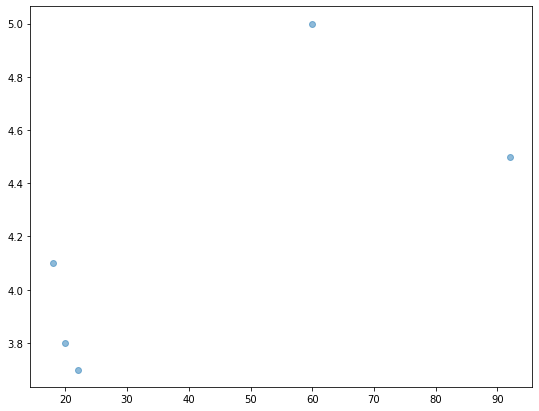

In [87]:
fig, ax = plt.subplots(figsize=(9, 7))

price_x = df[['price']]
user_rating_y = df['user_rating']
ax.scatter(price_x, user_rating_y, alpha=.5)

_x = np.linspace(price_x.min(), user_rating_y.max())
_y = lr.predict(_x)

ax.plot(_x, _y, color='orange')

In [93]:
# Create your feature matrix (X) and target vector (y)
X = X_train_combined.loc[:, ['price']]
y = df.loc[:, ['price']]

#y, x = patsy.dmatrices('X1 + X2 ~ y', data=combined_df, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

ValueError: The indices for endog and exog are not aligned

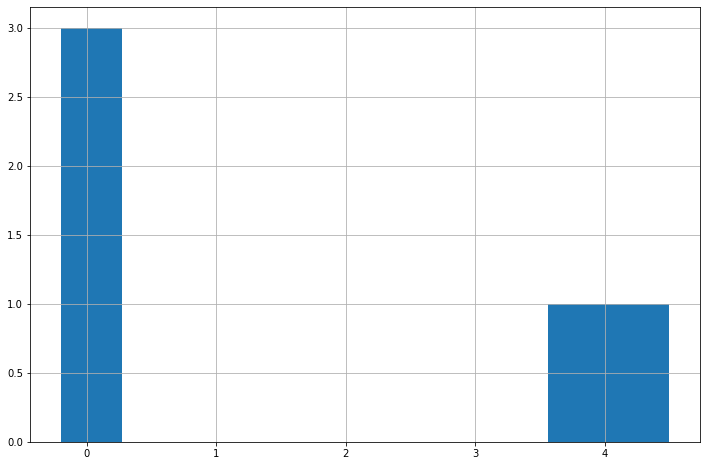

In [89]:
fit.resid.hist(figsize=(12,8));